In [1]:
# 필요한 package 불러오기

%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# **3. LOF Comparison with IF and OCSVM**

> Isolation Forest

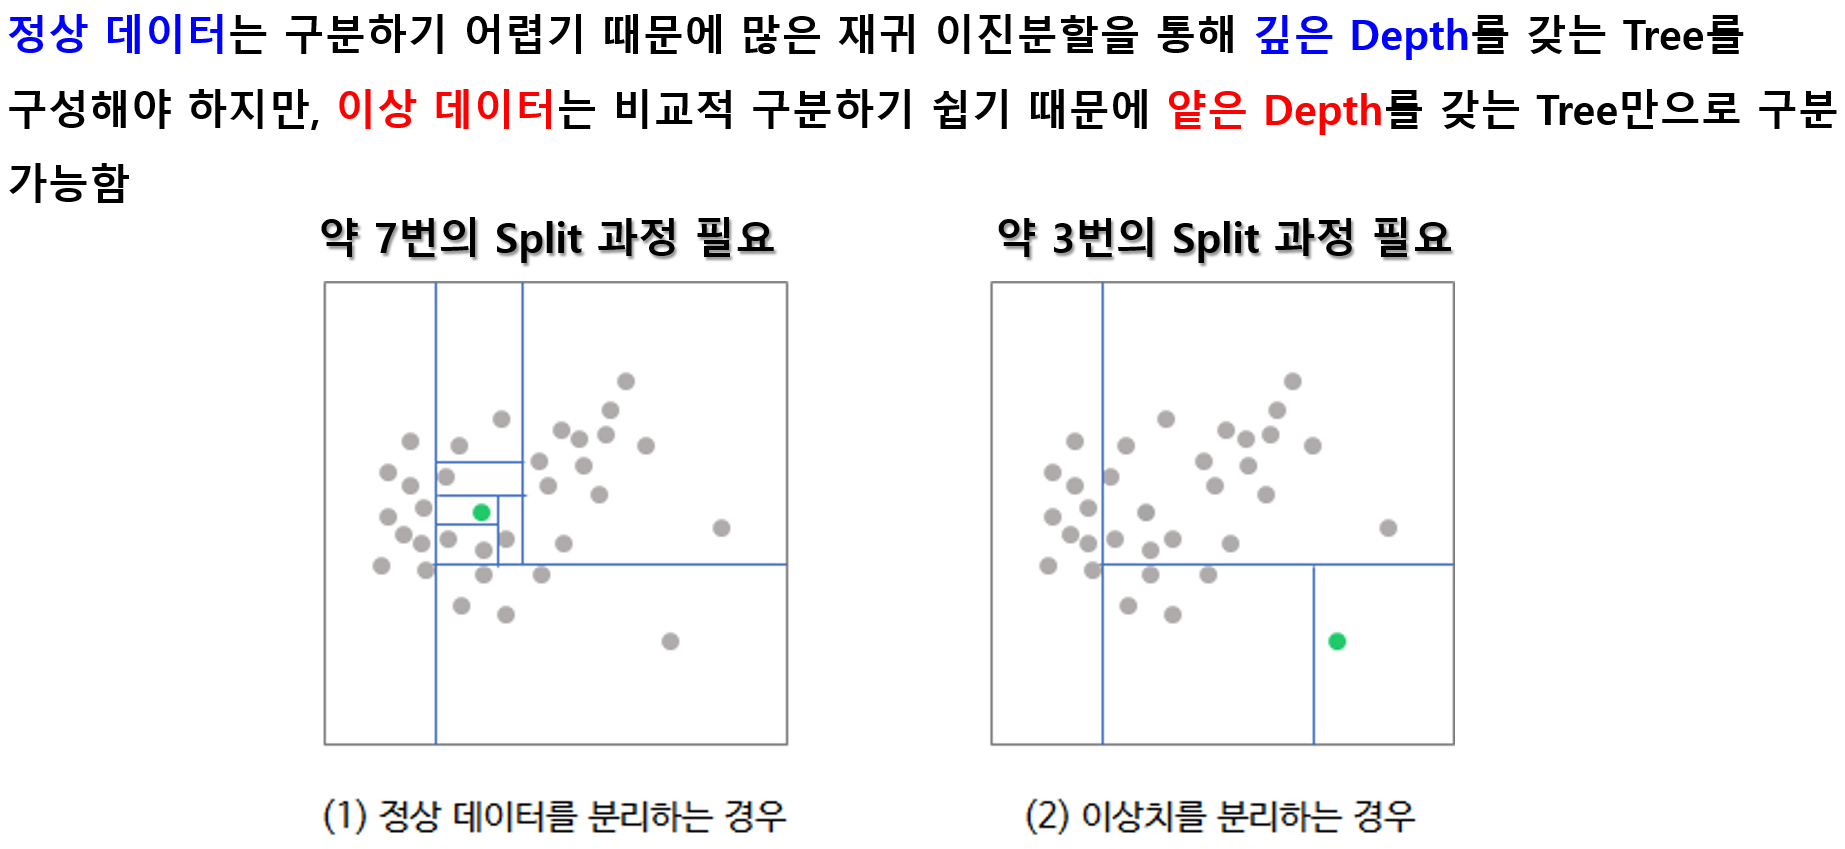

> Support Vector Machine

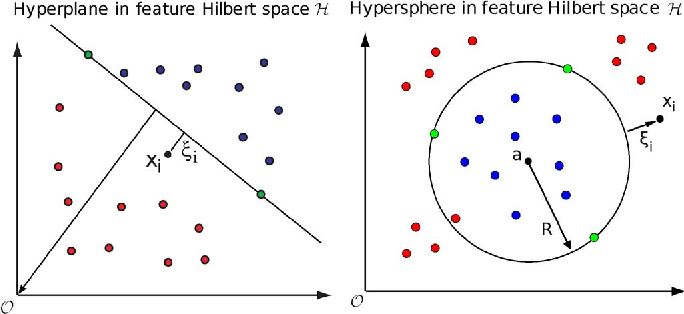

In [2]:
!git clone https://github.com/yun-seon/LGE_DIC_Training_0404.git

fatal: destination path 'LGE_DIC_Training_0404' already exists and is not an empty directory.


In [3]:
# load the dataset

data= pd.read_csv("/content/LGE_DIC_Training_0404/secom.csv")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/LGE_DIC_Training_0404/secom.csv'

In [ ]:
# droping the first column of the data

data = data.drop(['Time'], axis = 1)
data.shape

In [ ]:
# filling missing values

data.fillna(0, inplace = True)
print("NA counts: ", data.isnull().sum().sum())

data.head()

In [ ]:
data['Pass/Fail'].value_counts()

In [ ]:
data['Pass/Fail'][data['Pass/Fail'] == 1] = 1
data['Pass/Fail'][data['Pass/Fail'] == -1] = 0

data['Pass/Fail'].value_counts()

In [ ]:
# again creating x and y from the dataset
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

# getting the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

In [ ]:
# splittng the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 0)

# print the shapes
print("Shape of x_train :", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

### *Case 1. 이상치 비율을 알고 있는 경우*

In [ ]:
# defining outlier fraction

Fraud = data[data['Pass/Fail']==1]
Valid = data[data['Pass/Fail']==0]

outlier_fraction = len(Fraud)/float(len(Valid))
print("Outlier Fraction :", outlier_fraction)

In [ ]:
# fit the model for outlier detection
# use the default value of 20 nearest neighbors to measure the local deviation of the density

'''
LOF parameters (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)
  - n_neighbors: the number of neighbors
  - metric: the metric to use for distance computation (default is minkowski, which results in the standard Euclidean distance when p=2)
  - contamination: the proportion of outliers

IF parameters (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
  - n_neighbors: the number of base estimators in ensemble
  - max_samples: the number of samples to draw from X to train each base estimator
  - contamination: the proportion of outliers
'''

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=50, max_samples=len(x_train),
                                       contamination=outlier_fraction,random_state=0, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=5, algorithm='auto',
                                              leaf_size=30, metric='euclidean',
                                              p=2, metric_params=None, contamination=outlier_fraction)
}

In [ ]:
for i, (clf_name,clf) in enumerate(classifiers.items()):

    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred_lof = clf.fit_predict(x_test)
        y_pred = y_pred_lof
        scores_prediction = clf.negative_outlier_factor_
    else:
        clf.fit(x_train)
        scores_prediction = clf.decision_function(x_test)
        y_pred_if = clf.predict(x_test)
        y_pred = y_pred_if

    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_test).sum()

    # Run Classification Metrics
    print("\n{}: {}".format(clf_name, n_errors))
    print("Classification Report :")
    print(classification_report(y_test,y_pred))

### *Case 2. 정상 데이터만을 수집한 경우*

In [ ]:
# normal data filtering for training the models

x_train_normal = x_train.loc[y_train[y_train == 0].index,:]
y_train_normal = y_train[x_train_normal.index]

print("All points: ", x_train.shape, "\nNormal points", x_train_normal.shape)
print("All points: ", y_train.shape, "\nNormal points", y_train_normal.shape)

#### *(1) LOF algorithm*

In [ ]:
'''
LOF parameters (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)
  - n_neighbors: the number of neighbors
  - metric: the metric to use for distance computation (default is minkowski, which results in the standard Euclidean distance when p=2)
  - contamination: the proportion of outliers
'''

# define
clf_lof = LocalOutlierFactor(n_neighbors=5, algorithm='auto',
                                              leaf_size=30, metric='euclidean',
                                              p=2, metric_params=None)
# train
clf_lof.fit(x_train_normal)

# scoring
scores_tr = clf_lof.negative_outlier_factor_

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_tr))
plt.title('Distribution of LOF scores (train)', fontsize = 15)
plt.show()

In [ ]:
# set the thresholds

# case 1. percentile (10% 허용오차)
thres1 = np.percentile(np.abs(scores_tr), 90)

# case 2. percentile (5% 허용오차)
thres2 = np.percentile(np.abs(scores_tr), 95)

print("threshold (max): ", thres1, "threshold (percentile):", thres2)

# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_tr))
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of LOF scores (train)', fontsize = 15)
plt.show()

In [ ]:
# predict lof scores
clf_lof.fit(x_test)
scores_ts = clf_lof.negative_outlier_factor_

# make the results to the dataframe
results = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(np.abs(scores_ts))[0]], axis=1)
results.columns = ['Label', 'LOF Scores']

results['Pred_thres1'] = 0
results['Pred_thres2'] = 0
results.loc[results['LOF Scores'] > thres1, 'Pred_thres1'] = 1
results.loc[results['LOF Scores'] > thres2, 'Pred_thres2'] = 1

results

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_ts))
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of LOF scores (test)', fontsize = 15)
plt.show()

In [ ]:
results.Label.value_counts()

In [ ]:
results.Pred_thres1.value_counts() # use a threshold 1

In [ ]:
results.Pred_thres2.value_counts() # use a threshold 2

In [ ]:
print("Classification Report (threshold 1) :")
print(classification_report(results.Label.values, results.Pred_thres1.values))

In [ ]:
print("Classification Report (threshold 2) :")
print(classification_report(results.Label.values, results.Pred_thres2.values))

#### *(2) IF algorithm*

In [ ]:
'''
IF parameters (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
  - n_neighbors: the number of base estimators in ensemble
  - max_samples: the number of samples to draw from X to train each base estimator
  - contamination: the proportion of outliers
'''

# define
clf_if = IsolationForest(n_estimators=50, max_samples=len(x_train),
                                       random_state=0, verbose=0)

# train
clf_if.fit(x_train_normal)

# scoring
scores_tr = clf_if.decision_function(x_train_normal)

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_tr))
plt.title('Distribution of IF scores (train)', fontsize = 15)
plt.show()

In [ ]:
# set the thresholds

# threshold: mean +(-) 3*std
thres1 = np.mean(np.abs(scores_tr)) - 3*np.std(np.abs(scores_tr))
thres2 = np.mean(np.abs(scores_tr)) + 3*np.std(np.abs(scores_tr))

print("threshold (mean-3*std): ", thres1, "threshold (mean+3*std):", thres2)

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_tr))
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of IF scores (train)', fontsize = 15)
plt.show()

In [ ]:
# predict lof scores
scores_ts = clf_if.decision_function(x_test)

In [ ]:
# make the results to the dataframe
results = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(np.abs(scores_ts))[0]], axis=1)
results.columns = ['Label', 'IF Scores']

results['Pred_thres'] = 0
results.loc[(results['IF Scores'] < thres1)|(results['IF Scores'] > thres2), 'Pred_thres'] = 1

results

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(scores_ts))
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of IF scores (test)', fontsize = 15)
plt.show()

In [ ]:
results.Label.value_counts()

In [ ]:
results.Pred_thres.value_counts()

In [ ]:
print("Classification Report (threshold) :")
print(classification_report(results.Label.values, results.Pred_thres.values))

#### *(3) SVM algorithm*

In [ ]:
'''
OCSVM parameters (https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)
  - kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
  - degree: the degree of the polynomial kernel function
  - gamma: kernel coefficient for rbf/poly/sigmoid function
  - nu: an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
'''

# define
clf_svm = OneClassSVM(kernel='linear', degree=3, gamma=0.01,nu=0.05,
                                         max_iter=-1)
# train
clf_svm.fit(x_train_normal)

# scoring
scores_tr = clf_svm.score_samples(x_train_normal)

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(scores_tr)
plt.title('Distribution of SVM scores (train)', fontsize = 15)
plt.show()

In [ ]:
# set the thresholds

# case 1. percentile (하위 5% 허용오차)
thres1 = np.percentile(scores_tr, 5)

# case 2. percentile (상위 5% 허용오차)
thres2 = np.percentile(scores_tr, 95)

print("threshold (max): ", thres1, "threshold (percentile):", thres2)

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(scores_tr)
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of SVM scores (train)', fontsize = 15)
plt.show()

In [ ]:
# predict lof scores
scores_ts = clf_svm.score_samples(x_test)

In [ ]:
# make the results to the dataframe
results = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(scores_ts)[0]], axis=1)
results.columns = ['Label', 'SVM Scores']

results['Pred_thres'] = 0
results.loc[(results['SVM Scores'] < thres1)|(results['SVM Scores'] > thres2), 'Pred_thres'] = 1

results

In [ ]:
# visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(scores_ts)
plt.axvline(thres1, color = "r", linestyle = "--")
plt.axvline(thres2, color = "b", linestyle = "--")
plt.title('Distribution of SVM scores (test)', fontsize = 15)
plt.show()

In [ ]:
results.Label.value_counts()

In [ ]:
results.Pred_thres.value_counts()

In [ ]:
print("Classification Report (threshold) :")
print(classification_report(results.Label.values, results.Pred_thres.values))